In [1]:
%matplotlib ipympl
from IPython.display import Image as IImage
from IPython.display import HTML

from random import random

from PIL import Image

import trimesh

from shapely.geometry import MultiPolygon, GeometryCollection, Polygon, LineString, Point
from shapely.affinity import rotate

from panda3d.core import Triangulator

from matplotlib import pyplot as plt
import matplotlib.animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.image as mpimg

import numpy as np
import meshplot as mp

import os
from descartes import PolygonPatch

from polygon_utils import draw_multipolygon, extractpoints, mytriangulate, findpointid, ptinlist, trianglestofaces

[NbConvertApp] Converting notebook polygon_utils.ipynb to script
[NbConvertApp] Writing 4089 bytes to polygon_utils.py


In [2]:
INPUT_FOLDER = "entree"
NB_IMAGES = 30
WIDTH = 250
HEIGHT = 150

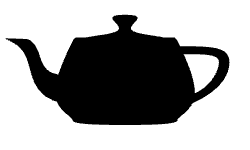

In [3]:
def load_images(folder_path):
    # Image format : 00001.png
    images = [None for i in range(30)]
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path).convert("L")  # Converts to grayscale
            images[int(filename[:5])-1] = img
    return images

images = load_images(INPUT_FOLDER)

images[0].save("entree.gif", save_all=True, append_images=images[1:], duration=100, loop=0)
IImage(filename="entree.gif")

Here we import the shadows of the object at different angles going from 0 to PI.

In [4]:
def union_multipoly(listmpoly):
    if len(listmpoly) == 0:
        return MultiPolygon()
    else:
        res = listmpoly[0]
        for mpoly in listmpoly:
            res = res.union(mpoly)
        return res

def intersection_multipoly(listmpoly):
    if len(listmpoly) == 0:
        raise ValueError("Intersection vide")
    else:
        res = listmpoly[0]
        for mpoly in listmpoly:
            res = res.intersection(mpoly)
        if isinstance(res, Polygon):
            return MultiPolygon([res])
        elif isinstance(res, MultiPolygon):
            return res
        else:
            print(res)
            return res

In [5]:
# For a given value of y, gives the list of the shadows of the layer at that
# height at the different angles
def processLayer(images, layer: int):
    longdistance = 3000
    multipolystointer = []
    for i in range(0, len(images), 1):
        # Computes the shadow of the layer i in the image of the shadoow at
        # angle i*180/30 in degrees
        polytounion = []
        points = []
        for x in range(-1, WIDTH):
            a = False if (x == -1) else images[i].getpixel((x, layer)) <= 120
            b = False if (x >= WIDTH - 1) else images[i].getpixel((x + 1, layer)) <= 120
            if (not (a) and b):
                points.append((x+1-WIDTH/2, longdistance))
                points.append((x+1-WIDTH/2, -longdistance))
            if (a and not (b)):
                points.append((x+1-WIDTH/2, -longdistance))
                points.append((x+1-WIDTH/2, longdistance))
                thepoly = rotate(Polygon(points), angle=i * 180 / 30, origin=(0,0))
                polytounion.append(thepoly)
                points = []
        multipolystointer.append(union_multipoly(polytounion))
    return multipolystointer

We will observe what happens at the layer y=60 the understand how we process the slice of our object from the shadows at that height

In [6]:
layer60 = processLayer(images, 60)

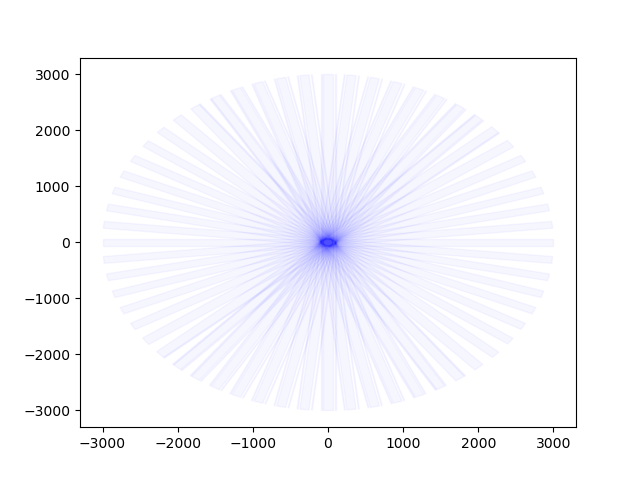

In [7]:
fig1, ax1 = plt.subplots()
for mpoly in layer60:
    draw_multipolygon(mpoly, ax1, alpha=1/NB_IMAGES)
plt.show()

Here you can see all the shadows at different angles of the layer y=60, you can zoom on one shadow to observe its shape and you can zoom in the middle to observe the intersection of the shadows and you can see that it looks like a slice of our object at layer y=60.

Now let's process the intersection of those shadows at each layer, we get a slice of our object at every height

In [8]:
multipolygons = [intersection_multipoly(processLayer(images, i)) for i in range(HEIGHT)]

In [9]:
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 100 
plt.ioff()
fig2, ax2 = plt.subplots()

def get_global_bounds(multipolygons):
    """Compute the global bounding box for all multipolygons."""
    min_x = min(p.bounds[0] for mp in multipolygons for p in mp.geoms)
    min_y = min(p.bounds[1] for mp in multipolygons for p in mp.geoms)
    max_x = max(p.bounds[2] for mp in multipolygons for p in mp.geoms)
    max_y = max(p.bounds[3] for mp in multipolygons for p in mp.geoms)
    return min_x, min_y, max_x, max_y

def animate(frame):
    ax2.clear()
    draw_multipolygon(multipolygons[frame], ax2, alpha=1)
    ax2.set_xlim(global_min_x, global_max_x)
    ax2.set_ylim(global_min_y, global_max_y)

global_min_x, global_min_y, global_max_x, global_max_y = get_global_bounds(multipolygons)

matplotlib.animation.FuncAnimation(fig2, animate, frames=len(multipolygons))

Now let's make a mesh out of those slices

In [10]:
class MyMesh:
    def __init__(self):
        self.vertices = []
        self.faces = []
        self.vertexID = 0

    def addVertex(self, pt):
        self.vertices.append(pt)
        self.vertexID += 1
        return self.vertexID - 1

    def addRectangle(self, aID, bID, cID, dID):
        self.faces += [(aID, bID, cID), (cID, dID, aID)]

    def addFaceToFace(self, ids1, ids2, multipol, reverse=False):
        if (isinstance(multipol, Polygon)):
            n = len(multipol.exterior.coords)
            for i in range(n):
                pt1 = multipol.exterior.coords[i]
                pt2 = multipol.exterior.coords[(i+1)%n]
                a = findpointid(ids1, pt2)
                b = findpointid(ids1, pt1)
                c = findpointid(ids2, pt1)
                d = findpointid(ids2, pt2)
                if (reverse):
                    self.addRectangle(d, c, b, a)
                else:
                    self.addRectangle(a, b, c, d)
            for interior in multipol.interiors:
                self.addFaceToFace(ids1, ids2, interior, reverse=True)
        elif (isinstance(multipol, MultiPolygon)):
            for pol in multipol.geoms:
                self.addFaceToFace(ids1, ids2, pol)

    def setpointsheight(self, pointids, height):
        for ptid in pointids:
            v = self.vertices[ptid]
            self.vertices[ptid] = (v[0], height, v[1])

    def addFace(self, f):
        self.faces.append(f)

    def plot(self):
        mp.plot(np.array(self.vertices), np.array(self.faces))

    def export(self, filename):
        with open(filename, 'w') as f:
            for v in self.vertices:
                f.write(f"v {v[0]} {v[1]} {v[2]}\n")
            for (a,b,c) in self.faces:
                f.write(f"f {a+1} {b+1} {c+1}\n")

testmesh = MyMesh()
pta = (0, 0)
a1 = testmesh.addVertex(pta)
ptb = (1, 0)
b1 = testmesh.addVertex(ptb)
ptc = (0, 1)
c1 = testmesh.addVertex(ptc)

a2 = testmesh.addVertex(pta)
b2 = testmesh.addVertex(ptb)
c2 = testmesh.addVertex(ptc)

testmesh.setpointsheight([a1, b1, c1], 0)
testmesh.setpointsheight([a2, b2, c2], 1)

testmesh.addFaceToFace([(a1, pta), (b1, ptb), (c1, ptc)], [(a2, pta), (b2, ptb), (c2, ptc)], Polygon([(0, 0), (1, 0), (0, 1)]))
print(testmesh.faces)
testmesh.plot()

[(1, 0, 3), (3, 4, 1), (2, 1, 4), (4, 5, 2), (0, 2, 5), (5, 3, 0), (0, 0, 3), (3, 3, 0)]


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5, 0.5,…

In [11]:
def mergetwoslices(mesh, poly1, poly2, y, visualize=None):
    polyinter = poly1.intersection(poly2)
    
    # Identify uniquely every point needed and add it to vertices
    thosepoints = []
    for pt in extractpoints(poly1):
        # if pt not in polyinter
        if not(ptinlist(extractpoints(polyinter), pt)):
            thosepoints.append((mesh.addVertex(pt), pt))
    for pt in extractpoints(poly2):
        # if pt not in polyinter
        if not(ptinlist(extractpoints(polyinter), pt)):
            thosepoints.append((mesh.addVertex(pt), pt))
    for pt in extractpoints(polyinter):
        thosepoints.append((mesh.addVertex(pt), pt))

    mesh.setpointsheight(map(lambda couple: couple[0], thosepoints), y)

    if visualize:
        xs, ys = zip(*map(lambda pt:pt[1],thosepoints))
        visualize.plot(xs, ys, 'gx')

    # triangulate the face poly1-poly2 and poly2-poly1
    poly1m2 = poly1.difference(poly2)
    poly2m1 = poly2.difference(poly1)
        
    triangles1m2 = mytriangulate(poly1m2)
    triangles2m1 = mytriangulate(poly2m1)
    
    if visualize:
        draw_multipolygon(MultiPolygon(triangles1m2), visualize, color='red', alpha=0.1)
        draw_multipolygon(MultiPolygon(triangles2m1), visualize, color='black', alpha=0.1)

    mesh.faces += trianglestofaces(thosepoints, triangles1m2)
    mesh.faces += trianglestofaces(thosepoints, triangles2m1, reverse=True)

    pol1IDs = [findpointid(thosepoints, pt) for pt in extractpoints(poly1)]
    pol2IDs = [findpointid(thosepoints, pt) for pt in extractpoints(poly2)]

    return thosepoints

meshexemple = MyMesh()

poly1 = MultiPolygon([Polygon([(0, 0), (2, 0), (2, 2), (0, 2)]), Polygon([(4,0), (5, 0), (5, 2), (4, 2)])])
poly2 = MultiPolygon([Polygon([(1, 1.5), (5, 0), (4, 0.5), (4, 1), (3, 1.5), (4, 2)]), Polygon([(0.5, 0.5), (0.7, 0.5), (0.7, 0.7)])])

_, axtestMerge = plt.subplots()

draw_multipolygon(poly1, axtestMerge, color='green', alpha=0.1)
draw_multipolygon(poly2, axtestMerge, color='blue', alpha=0.1)
mergetwoslices(meshexemple, poly1, poly2, 60.5, visualize=axtestMerge)
print(meshexemple.vertices)
print(meshexemple.faces)
plt.show()

[(0.0, 60.5, 0.0), (2.0, 60.5, 0.0), (2.0, 60.5, 2.0), (0.0, 60.5, 2.0), (0.0, 60.5, 0.0), (4.0, 60.5, 0.0), (5.0, 60.5, 2.0), (4.0, 60.5, 0.0), (3.0, 60.5, 1.5), (2.0, 60.5, 1.125), (1.0, 60.5, 1.5), (2.0, 60.5, 1.6666666666666667), (2.0, 60.5, 1.125), (4.0, 60.5, 0.5), (5.0, 60.5, 0.0), (4.0, 60.5, 0.375), (4.0, 60.5, 0.5), (0.7, 60.5, 0.7), (0.7, 60.5, 0.5), (0.5, 60.5, 0.5), (0.7, 60.5, 0.7), (4.0, 60.5, 1.0), (4.0, 60.5, 0.5), (4.0, 60.5, 2.0)]
[(3, 4, 19), (3, 19, 20), (3, 20, 10), (3, 10, 2), (2, 10, 11), (1, 12, 18), (1, 18, 4), (4, 18, 19), (20, 18, 12), (20, 12, 10), (15, 7, 14), (23, 21, 6), (6, 21, 14), (14, 21, 22), (8, 12, 11), (23, 8, 11), (8, 22, 15), (12, 8, 15), (21, 22, 8)]


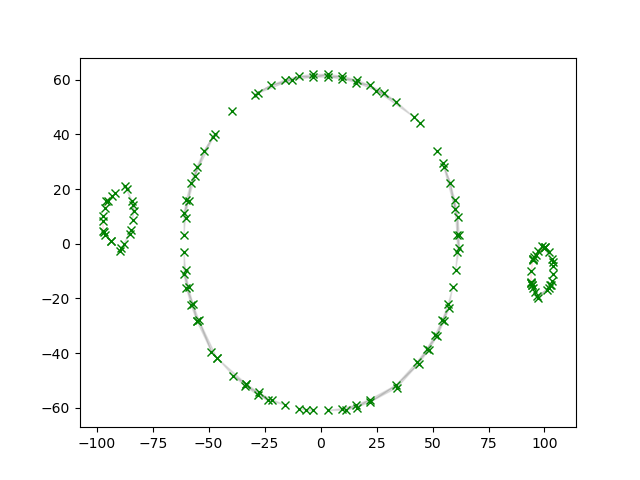

In [12]:
_, axdebug = plt.subplots()
layer = 60
poly1 = multipolygons[layer]
poly2 = multipolygons[layer+1]
draw_multipolygon(poly1, axtestMerge, color='green', alpha=0.1)
draw_multipolygon(poly2, axtestMerge, color='blue', alpha=0.1)
mergetwoslices(meshexemple, poly1, poly2, 60.5, visualize=axdebug)
plt.show()

In [13]:
def layerstomesh(layers):
    res = MyMesh()
    previouspoints = []
    for i in range(-1, HEIGHT):
        poly1 = MultiPolygon() if (i == -1) else layers[i]
        poly2 = MultiPolygon() if (i == HEIGHT - 1) else layers[i + 1]
        y = HEIGHT / 2 - i - 0.5

        #build side faces
        thosepoints = mergetwoslices(res, poly1, poly2, y)
        res.addFaceToFace(previouspoints, thosepoints, poly1)
        previouspoints = thosepoints
    return res

In [14]:
mesh = layerstomesh(multipolygons)
mesh.plot()
mesh.export("out.obj")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-7.479297…